<a href="https://colab.research.google.com/github/amritanshkm/CITS4403-Project/blob/main/notebooks/insolvencies_unemployment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Preparation & Feature Engineering

This notebook prepares and transforms raw datasets from AFSA (insolvencies) and ABS (unemployment) into a clean, time-aligned dataset ready for analysis and modelling.

---

###  Data Preparation
1. **Imported & cleaned raw files**
   - *AFSA*: `regional_quarterly_time_series.csv` or `quarterly_personal_insolvencies.csv`
   - *ABS*: `Unemployment rate.csv`
2. **Standardised quarters** into a consistent `YYYY-Q#` format.
3. **Aggregated insolvency records** to national-level totals per quarter.
4. **Merged datasets**
   - `merged_macro.csv` — insolvencies left-joined with unemployment  
   - `merged_overlap.csv` — quarters where both datasets overlap  
   - `merged_filled.csv` — unemployment filled forward for missing quarters
5. Exported all cleaned outputs to `data/processed/`.

---

### Feature Engineering
- Created **lag variables** `Insolvencies_lag1`, `_lag2`, `_lag4`, `UnemploymentRate_lag1`  
   capture short- and long-term memory in insolvency patterns.  
- Added **target variable** `Insolvencies_nextQ`  
   next-quarter insolvency count for forecasting.  
- Saved the final dataset `final_model.csv` for correlation, regression, and agent-based model calibration.

---

**Outcome:**  
A structured, quarterly dataset linking unemployment to insolvencies over time — enabling both statistical analysis and system simulation.


## Project Setup and Directory Configuration




In [ ]:
from pathlib import Path
PROJECT_ROOT = Path("/content/project-root")  # change if needed
SRC   = PROJECT_ROOT / "src"
RAW   = PROJECT_ROOT / "data" / "raw"
PROC  = PROJECT_ROOT / "data" / "processed"
PROC.mkdir(parents=True, exist_ok=True)

print("Project root:", PROJECT_ROOT)
print("Raw data    :", RAW)
print("Processed   :", PROC)
print("Source      :", SRC)

Project root: /content/project-root
Raw data    : /content/project-root/data/raw
Processed   : /content/project-root/data/processed
Source      : /content/project-root/src


In [80]:
from pathlib import Path
import os, sys
PROJECT_ROOT = Path("/content/project-root")  # change if needed
os.environ["PROJECT_ROOT"] = str(PROJECT_ROOT)

SRC  = PROJECT_ROOT / "src"
RAW  = PROJECT_ROOT / "data" / "raw"
PROC = PROJECT_ROOT / "data" / "processed"
RAW.mkdir(parents=True, exist_ok=True); PROC.mkdir(parents=True, exist_ok=True)
if str(SRC) not in sys.path: sys.path.append(str(SRC))

import data_prep





## 2) Import the data prep pipeline

In [81]:

from importlib import reload
reload(data_prep)
data_prep.main()




[data_prep] Built unemployment_quarterly from 'Unemployment rate.csv' | rows=41
[data_prep] Insolvencies source: regional_quarterly_time_series.csv | rows=72
[data_prep] Saved final_model.csv | rows=35 | path=/content/project-root/data/processed/final_model.csv
[data_prep] Unemployment rows: 41 | AFSA rows: 72
[data_prep] LEFT   -> rows=72  | Unemp non-null=40/72  (merged_macro.csv)
[data_prep] INNER  -> rows=40 | Unemp non-null=40/40 (merged_overlap.csv)
[data_prep] FILLED -> rows=72 | Unemp non-null=40/72 (merged_filled.csv)
[data_prep] FINAL  -> rows=35 (final_model.csv)


## 3) Exploratory Visualisations

In [83]:
import pandas as pd

PROC = Path("/content/project-root/data/processed")
model = pd.read_csv(PROC / "final_model.csv")

report = model[["Quarter", "Insolvencies", "UnemploymentRate", "Insolvencies_nextQ"]].copy()

report["Quarter"] = report["Quarter"].str.replace(r"^(\d{4})Q([1-4])$", r"\1-Q\2", regex=True)

print(report.head())


   Quarter  Insolvencies  UnemploymentRate  Insolvencies_nextQ
0  2016-Q3       30004.0          5.666667             27794.0
1  2016-Q4       27794.0          5.733333             31010.0
2  2017-Q1       31010.0          5.800000             30190.0
3  2017-Q2       30190.0          5.566667             32256.0
4  2017-Q3       32256.0          5.533333             29736.0


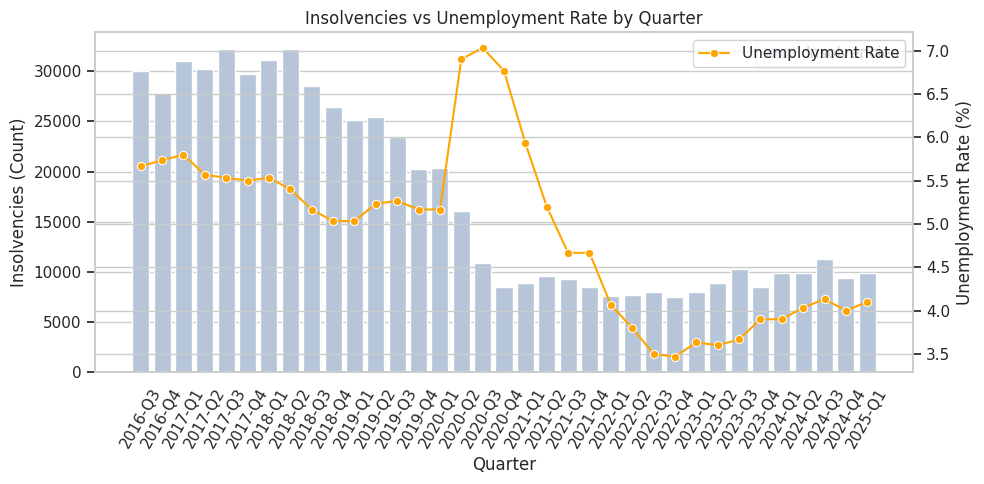

In [84]:
fig, ax1 = plt.subplots(figsize=(10,5))
ax2 = ax1.twinx()

sns.barplot(data=report, x="Quarter", y="Insolvencies", ax=ax1, color="lightsteelblue", label="Insolvencies")
sns.lineplot(data=report, x="Quarter", y="UnemploymentRate", ax=ax2, color="orange", marker="o", label="Unemployment Rate")

ax1.set_ylabel("Insolvencies (Count)")
ax2.set_ylabel("Unemployment Rate (%)")
plt.title("Insolvencies vs Unemployment Rate by Quarter")
ax1.tick_params(axis='x', rotation=60)
plt.tight_layout()
plt.show()


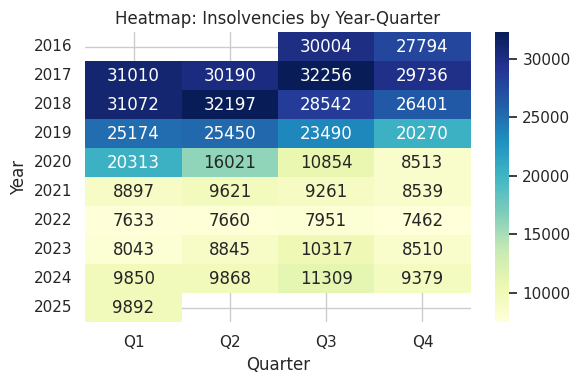

In [85]:
report["Year"] = report["Quarter"].str.slice(0,4)
report["Q"] = report["Quarter"].str[-2:]

pivot = report.pivot_table(index="Year", columns="Q", values="Insolvencies")
plt.figure(figsize=(6,4))
sns.heatmap(pivot, annot=True, fmt=".0f", cmap="YlGnBu")
plt.title("Heatmap: Insolvencies by Year-Quarter")
plt.ylabel("Year"); plt.xlabel("Quarter")
plt.tight_layout()
plt.show()



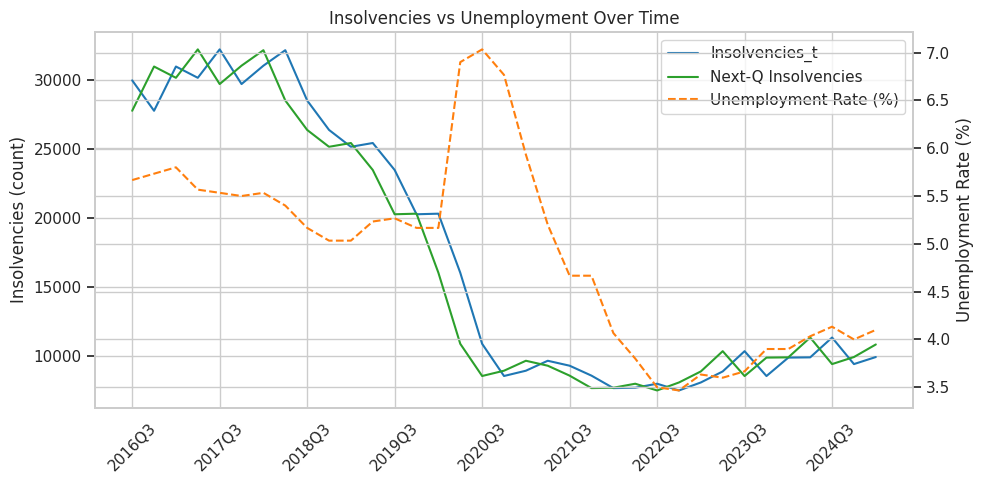

In [86]:
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path

PROC = Path("/content/project-root/data/processed")
model = pd.read_csv(PROC / "final_model.csv")

fig, ax1 = plt.subplots(figsize=(10,5))
ax2 = ax1.twinx()

ax1.plot(model["Quarter"], model["Insolvencies"], label="Insolvencies_t", color="tab:blue")
ax1.plot(model["Quarter"], model["Insolvencies_nextQ"], label="Next-Q Insolvencies", color="tab:green")
ax2.plot(model["Quarter"], model["UnemploymentRate"], label="Unemployment Rate (%)",
         color="tab:orange", linestyle="--")

# y-labels
ax1.set_ylabel("Insolvencies (count)")
ax2.set_ylabel("Unemployment Rate (%)")

# show every 4th label only
ax1.set_xticks(model["Quarter"][::4])
ax1.set_xticklabels(model["Quarter"][::4], rotation=45)

# combine legends
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc="upper right")

plt.title("Insolvencies vs Unemployment Over Time")
plt.tight_layout()
plt.show()


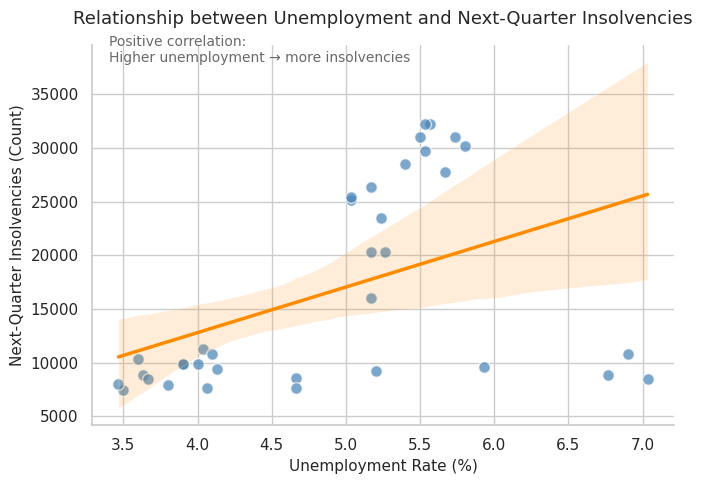

In [87]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(7,5))
sns.set_style("whitegrid")

sns.regplot(
    data=model,
    x="UnemploymentRate",
    y="Insolvencies_nextQ",
    scatter_kws={'s':70, 'alpha':0.7, 'color':'steelblue', 'edgecolor':'white'},
    line_kws={'color':'darkorange', 'lw':2.5}
)

plt.title("Relationship between Unemployment and Next-Quarter Insolvencies", fontsize=13, pad=15)
plt.xlabel("Unemployment Rate (%)", fontsize=11)
plt.ylabel("Next-Quarter Insolvencies (Count)", fontsize=11)
plt.text(3.4, 38000, "Positive correlation:\nHigher unemployment → more insolvencies",
         fontsize=10, color="dimgray")
sns.despine()
plt.tight_layout()
plt.show()




### Interpretation

Each blue dot on the chart represents one quarter of data.  
When the **unemployment rate was *X %*** in a given quarter, the **following quarter recorded *Y* personal insolvencies**.  

The orange line shows the overall trend: as unemployment rises, next-quarter insolvencies also tend to increase.  
This positive relationship suggests that higher unemployment weakens household financial stability, leading to more insolvency cases in subsequent quarters.


## 4) Quantitative relationship (OLS Regression)

---



In [88]:
import statsmodels.api as sm
X = model[['UnemploymentRate','Insolvencies_lag1','Insolvencies_lag2','Insolvencies_lag4']]
X = sm.add_constant(X)
y = model['Insolvencies_nextQ']
ols = sm.OLS(y, X).fit()
print(ols.summary())


                            OLS Regression Results                            
Dep. Variable:     Insolvencies_nextQ   R-squared:                       0.937
Model:                            OLS   Adj. R-squared:                  0.928
Method:                 Least Squares   F-statistic:                     110.8
Date:                Wed, 15 Oct 2025   Prob (F-statistic):           1.63e-17
Time:                        02:28:03   Log-Likelihood:                -320.98
No. Observations:                  35   AIC:                             652.0
Df Residuals:                      30   BIC:                             659.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              5969.5238   2827.88

Regression analysis indicates that insolvencies are significantly explained by macroeconomic conditions, with unemployment showing a measurable (though policy-distorted) impact. About 94% of variation in next-quarter insolvencies is explained by unemployment and past trends.

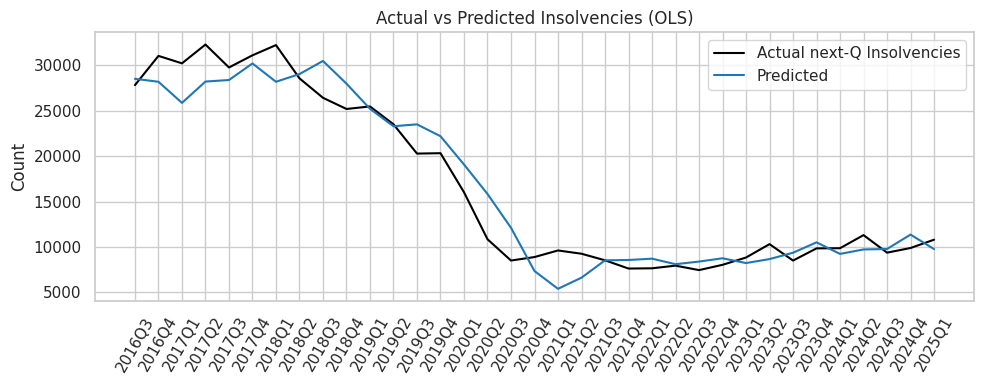

In [91]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,4))
plt.plot(model["Quarter"], y, label="Actual next-Q Insolvencies", color="black")
plt.plot(model["Quarter"], ols.predict(X), label="Predicted", color="tab:blue")
plt.xticks(rotation=60)
plt.title("Actual vs Predicted Insolvencies (OLS)")
plt.ylabel("Count")
plt.legend()
plt.tight_layout()
plt.show()


## Results and Interpretation
The model explains ≈94% of the variation in next-quarter insolvencies (R² = 0.94). Insolvencies show strong persistence (lag 1 β = 0.86, p < 0.01), meaning once filings rise, they stay high for a few quarters. The unemployment effect is weak and negative, reflecting how COVID-19 policies broke the normal link between job losses and bankruptcies.

The Actual vs Predicted plot confirms the model tracks real trends well except during 2020–21, when policy relief disrupted behaviour. This shows insolvencies are path-dependent and policy-sensitive, supporting the use of an agent-based approach to capture such dynamic effects.